In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

# Importing the Dataset from TensorFlow #

In [179]:
data_train = tfds.load('mnist', split='train', as_supervised=True)
data_test = tfds.load('mnist', split='test', as_supervised=True)

data_train = tfds.as_numpy(data_train.take(5000))
data_test = tfds.as_numpy(data_test.take(1000))

In [180]:
X_train = pd.DataFrame()
y_train = pd.DataFrame()

X_test = pd.DataFrame()
y_test = pd.DataFrame()

for image, label in data_train:
    X_train = X_train.append(pd.DataFrame(image.flatten()).T, ignore_index=True)
    y_train = y_train.append([label], ignore_index=True)

for image, label in data_test:
    X_test = X_test.append(pd.DataFrame(image.flatten()).T, ignore_index=True)
    y_test = y_test.append([label], ignore_index=True)

In [181]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [182]:
y_train

,0
0,4
1,1
2,0
3,7
4,8
...,...
4995,8
4996,6
4997,3
4998,5


Scaling the data

In [183]:
X_train = X_train.to_numpy().T / 255
y_train = y_train.to_numpy().T[0]

X_test = X_test.to_numpy().T / 255
y_test = y_test.to_numpy().T[0]

In [184]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [185]:
y_train

array([4, 1, 0, ..., 3, 5, 0], dtype=int64)

# Main Convolutional Neural Network Code #

In [186]:
def init_params():
    W1 = 0.1 * np.random.randn(10, 784)
    b1 = np.zeros((10, 1))

    W2 = 0.1 * np.random.randn(10, 10)
    b2 = np.zeros((10, 1))

    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(0, Z)

def deriv_ReLU(Z):
    return Z > 0

def SoftMax(Z):
    exp = np.exp(Z - np.max(Z))
    return exp / np.sum(exp, axis=0)

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)

    Z2 = W2.dot(A1) + b2
    A2 = SoftMax(Z2)

    return Z1, A1, Z2, A2

def one_hot(y):
    one_hotY = np.zeros((y.size, y.max() + 1))
    one_hotY[np.arange(y.size), y] = 1
    one_hotY = one_hotY.T
    
    return one_hotY

def back_prop(Z1, A1, Z2, A2, W2, X, y):
    m = y.size
    one_hotY = one_hot(y)

    dZ2 = A2 - one_hotY
    dW2 = (1 / m) * (dZ2.dot(A1.T))
    db2 = (1 / m) * (np.sum(dZ2))

    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = (1 / m) * (dZ1.dot(X.T))
    db1 = (1 / m) * (np.sum(dZ1))

    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - (alpha * dW1)
    b1 = b1 - (alpha * db1)

    W2 = W2 - (alpha * dW2)
    b2 = b2 - (alpha * db2)

    return W1, b1, W2, b2

In [187]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, y):
    print(predictions, y)
    return sum(predictions == y) / y.size

def gradient_descent(X, y, iterations, alpha):
    W1, b1, W2, b2 = init_params()

    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, X, y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        if(i % 50 == 0):
            print(f'Iteration: {i}')
            print(f'Accuracy: {get_accuracy(get_predictions(A2), y)}')

    return W1, b1, W2, b2

In [188]:
W1, b1, W2, b2 = gradient_descent(X_train, y_train, 1000, 0.1)

Iteration: 0
[4 3 7 ... 8 0 7] [4 1 0 ... 3 5 0]
Accuracy: 0.0576
Iteration: 50
[9 1 0 ... 3 4 0] [4 1 0 ... 3 5 0]
Accuracy: 0.5116
Iteration: 100
[9 1 0 ... 3 9 0] [4 1 0 ... 3 5 0]
Accuracy: 0.7324
Iteration: 150
[9 1 0 ... 3 4 0] [4 1 0 ... 3 5 0]
Accuracy: 0.7898
Iteration: 200
[9 1 0 ... 3 5 0] [4 1 0 ... 3 5 0]
Accuracy: 0.8226
Iteration: 250
[4 1 0 ... 3 5 0] [4 1 0 ... 3 5 0]
Accuracy: 0.8442
Iteration: 300
[4 1 0 ... 3 5 0] [4 1 0 ... 3 5 0]
Accuracy: 0.8604
Iteration: 350
[4 1 0 ... 3 5 0] [4 1 0 ... 3 5 0]
Accuracy: 0.8702
Iteration: 400
[4 1 0 ... 3 5 0] [4 1 0 ... 3 5 0]
Accuracy: 0.8806
Iteration: 450
[4 1 0 ... 3 5 0] [4 1 0 ... 3 5 0]
Accuracy: 0.8894
Iteration: 500
[4 1 0 ... 3 5 0] [4 1 0 ... 3 5 0]
Accuracy: 0.8922
Iteration: 550
[4 1 0 ... 3 5 0] [4 1 0 ... 3 5 0]
Accuracy: 0.8988
Iteration: 600
[4 1 0 ... 3 5 0] [4 1 0 ... 3 5 0]
Accuracy: 0.902
Iteration: 650
[4 1 0 ... 3 5 0] [4 1 0 ... 3 5 0]
Accuracy: 0.9068
Iteration: 700
[4 1 0 ... 3 5 0] [4 1 0 ... 3 5 0]
A

In [189]:
def make_prediction(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)

    return predictions

def test_prediction(index, dataX, datay, W1, b1, W2, b2):
    if(index == None):
        index = np.arange(len(dataX))

    current_image = dataX[:, index, None]

    if(type(index) == np.ndarray):
        prediction = make_prediction(dataX, W1, b1, W2, b2)

        return prediction
    else:
        prediction = make_prediction(dataX[:, index, None], W1, b1, W2, b2)

        label = datay[index]
        print(f'Prediction: {prediction}')
        print(f'Label: {label}')

    if(type(index) != np.ndarray):
        current_image = current_image.reshape((28, 28)) * 255
        
        plt.gray()
        plt.imshow(current_image, interpolation='nearest')
        plt.show()

Testing the Model

Prediction: [6]
Label: 6


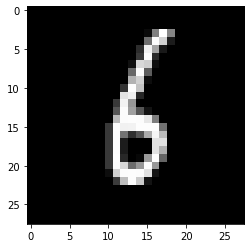

Prediction: [6]
Label: 6


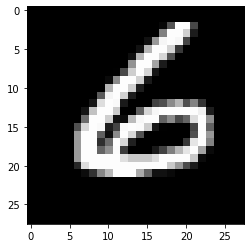

Prediction: [7]
Label: 7


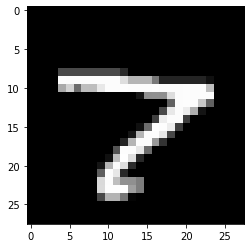

Prediction: [4]
Label: 4


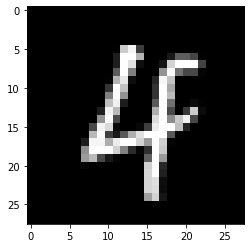

Prediction: [0]
Label: 9


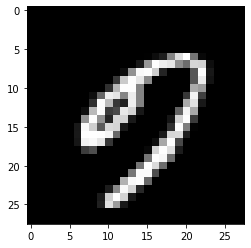

In [190]:
test_prediction(26, X_test, y_test, W1, b1, W2, b2)
test_prediction(27, X_test, y_test, W1, b1, W2, b2)
test_prediction(28, X_test, y_test, W1, b1, W2, b2)
test_prediction(29, X_test, y_test, W1, b1, W2, b2)
test_prediction(30, X_test, y_test, W1, b1, W2, b2)

Testing on the rest of the Test Data

In [191]:
test_predictions = test_prediction(None, X_test, y_test, W1, b1, W2, b2)
get_accuracy(test_predictions, y_test)

[2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 0 3 8 9 5 4 2
 5 5 8 5 2 9 2 4 2 9 0 5 1 0 7 9 9 9 6 5 8 8 6 9 0 5 4 2 6 8 1 0 6 9 5 5 4
 1 6 7 5 2 9 0 6 4 4 3 8 7 8 5 0 9 0 1 1 9 4 5 9 1 6 6 0 7 7 3 4 8 8 1 8 0
 2 9 1 0 3 9 7 0 4 9 6 8 3 3 5 4 3 2 8 4 0 3 2 3 3 1 1 2 4 8 2 2 6 8 6 1 3
 0 6 3 7 2 3 4 4 6 7 0 8 2 8 6 0 9 7 3 2 9 0 2 3 2 8 7 0 1 7 8 5 1 2 3 1 9
 8 7 9 0 8 3 9 3 9 7 4 9 3 1 2 2 6 0 7 6 9 3 9 7 4 2 0 1 0 4 9 9 1 9 2 2 5
 5 6 0 0 0 7 7 4 2 5 1 7 7 8 2 5 9 6 6 8 0 1 2 1 7 7 7 3 0 3 4 8 3 6 3 8 2
 0 7 5 7 2 0 8 5 8 6 7 1 7 1 0 1 8 6 5 1 2 3 1 9 0 9 5 2 1 0 0 6 1 4 1 7 1
 2 4 4 8 9 1 0 8 5 8 5 8 9 9 1 8 0 1 3 9 7 1 8 4 6 7 6 6 2 1 2 4 7 7 7 2 0
 7 2 8 9 1 7 2 9 5 0 0 4 2 7 5 3 5 8 5 3 6 6 0 8 9 2 8 2 2 6 3 2 2 1 8 1 7
 6 4 7 2 2 6 3 2 9 6 6 3 7 6 6 4 9 6 8 5 1 6 9 4 7 1 1 6 8 0 6 1 4 9 9 6 7
 7 6 8 9 5 4 7 0 6 3 8 0 9 0 1 1 2 7 6 2 2 6 2 6 1 3 3 3 6 6 4 1 1 3 0 7 6
 0 5 0 8 8 3 1 1 9 4 7 9 3 6 5 9 3 2 6 9 6 2 2 4 0 0 1 2 5 5 1 8 7 8 1 9 7
 8 5 5 7 1 0 5 4 4 2 3 9 

0.905